<a href="https://colab.research.google.com/github/TheS1n233/Distributed-Learning-Project5/blob/test/YUJIE-Centralized%20baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# install torch and torchvi

In [ ]:
!pip install torch torchvision matplotlib


# install dataset CIFAR-100

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms


# Data preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Download CIFAR-100 dataset
train_dataset = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform)

# Split training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

# Create data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64, shuffle=False)

# # split dataset for workers
# def split_dataset(dataset, num_workers):
#     """将数据集拆分为 num_workers 份"""
#     worker_datasets = torch.utils.data.random_split(
#         dataset, [len(dataset) // num_workers] * num_workers
#     )
#     return worker_datasets

# # Number of workers
# K = 4  # Assume 4 workers
# Bloc = 64  # Local batch size
# worker_datasets = split_dataset(train_dataset, K)
# worker_loaders = [
#     torch.utils.data.DataLoader(ds, batch_size=Bloc, shuffle=True) for ds in worker_datasets
# ]


100%|██████████| 169M/169M [00:18<00:00, 9.15MB/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


# Centralized baseline

Training with SGDM optimizer...
Epoch 1/150, Train Loss: 4.5598, Train Acc: 1.70%, Val Loss: 4.3505, Val Acc: 3.59%
Epoch 2/150, Train Loss: 4.1642, Train Acc: 5.64%, Val Loss: 3.9694, Val Acc: 8.18%
Epoch 3/150, Train Loss: 3.9076, Train Acc: 9.09%, Val Loss: 3.7873, Val Acc: 11.19%
Epoch 4/150, Train Loss: 3.7534, Train Acc: 11.60%, Val Loss: 3.6556, Val Acc: 13.65%
Epoch 5/150, Train Loss: 3.6353, Train Acc: 13.46%, Val Loss: 3.5253, Val Acc: 16.10%
Epoch 6/150, Train Loss: 3.5433, Train Acc: 15.16%, Val Loss: 3.5183, Val Acc: 15.52%
Epoch 7/150, Train Loss: 3.4620, Train Acc: 16.93%, Val Loss: 3.3951, Val Acc: 17.81%
Epoch 8/150, Train Loss: 3.4033, Train Acc: 17.89%, Val Loss: 3.3540, Val Acc: 19.17%
Epoch 9/150, Train Loss: 3.3566, Train Acc: 18.39%, Val Loss: 3.3388, Val Acc: 19.72%
Epoch 10/150, Train Loss: 3.3222, Train Acc: 19.23%, Val Loss: 3.3236, Val Acc: 19.17%
Epoch 11/150, Train Loss: 3.2824, Train Acc: 20.15%, Val Loss: 3.2664, Val Acc: 21.19%
Epoch 12/150, Train Loss:

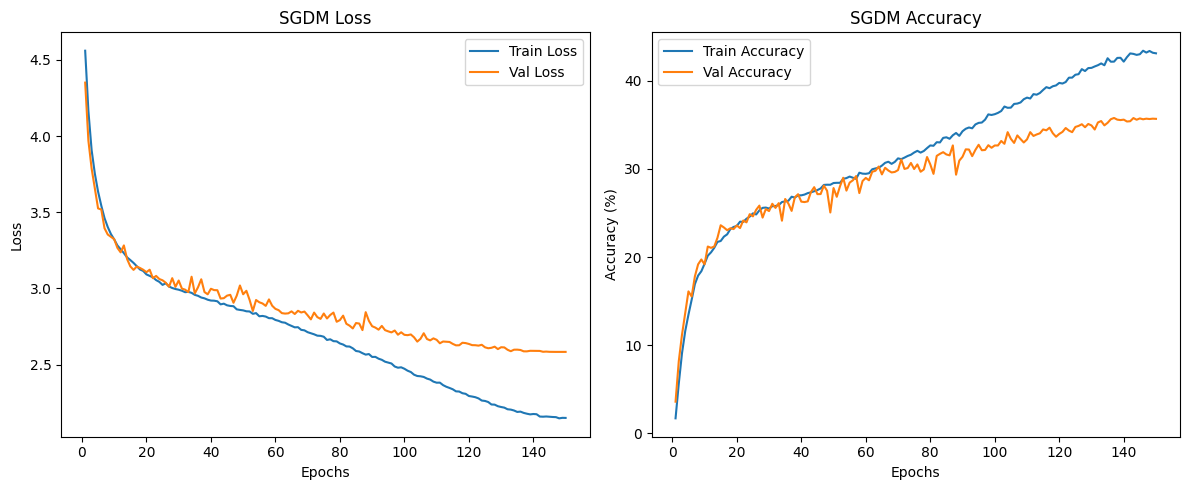

In [ ]:

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
# define LeNet-5 model
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.dropout1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(120, 84)
        self.dropout2 = nn.Dropout(0.1)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout1(x)
        x = F.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


# Initialize device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training function
def train_model(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100. * correct / total)

        # Validation phase
        model.eval()
        val_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100. * correct / total)

        scheduler.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    return train_losses, val_losses, train_accuracies, val_accuracies

# Test function
def test_model(model, test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Test Accuracy: {100. * correct / total:.2f}%")

# Training configurations
num_epochs = 150
criterion = nn.CrossEntropyLoss()

# Train with SGDM
model = LeNet5().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
print("Training with SGDM optimizer...")
train_losses_sgdm, val_losses_sgdm, train_acc_sgdm, val_acc_sgdm = train_model(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)
test_model(model, test_loader)

# Train with AdamW
model = LeNet5().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.0015, weight_decay=0.005)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
print("Training with AdamW optimizer...")
train_losses_adamw, val_losses_adamw, train_acc_adamw, val_acc_adamw = train_model(model, optimizer, criterion, scheduler, train_loader, val_loader, num_epochs)
test_model(model, test_loader)

# Plot training and validation results
def plot_results(train_losses, val_losses, train_accuracies, val_accuracies, title):
    epochs = range(1, num_epochs + 1)
    plt.figure(figsize=(12, 5))

    # Plot losses
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'{title} Loss')
    plt.legend()

    # Plot accuracies
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title(f'{title} Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot results for SGDM
plot_results(train_losses_sgdm, val_losses_sgdm, train_acc_sgdm, val_acc_sgdm, 'SGDM')

# Plot results for AdamW
plot_results(train_losses_adamw, val_losses_adamw, train_acc_adamw, val_acc_adamw, 'AdamW')


import os
from google.colab import runtime
print("All code has finished running. Disconnecting GPU to save free time...")
runtime.unassign()